In [15]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from rikabplotlib.plot_utils import newplot

import torch
import zuko

In [16]:
# Physics Parameters
E0 = 500
R = 0.4
N = 1


# Training Params
MODE = "UNIFORM_SAMPLES" #"UNIFORM_SAMPLES"

# LOSS = "FORWARD"
# LOSS = "REVERSE"
LOSS = "residual"
# LOSS = "ratioMSE"

DEBUG = True

epochs = 1250*2
batch_size_x = 64
batch_size_alpha = 8

batch_conditional = 8
lr = 1e-3
auxiliary_params = 0 # Number of auxiliary parameters to use in the model, 0 has different behavior!
num_transforms = 3 # I think this is the number of layers?
hidden_features=(8, 8)
x_range = (0, 1) # Range of x values to train on, should be at least as large as the support of the data


In [17]:
# Distribution Choices:

def Gaussian(x):

    mean = 0
    std = 1

    # Gaussian 
    p = 1/np.sqrt(2 * np.pi  * std**2) * np.exp(- (x - mean)**2 / 2 / std**2)
    return p

def Uniform(x): 

    return Theta(x) * Theta(1 - x)


def Theta(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

def alpha_s(scale, lambda_qcd = 0.2):
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def dalpha_dscale(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return -4 * np.pi / beta_0  / (torch.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale


def alpha_s(scale, lambda_qcd = 0.2):
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def lambda_qcd(alpha0, scale0):

    beta_0 = 11 - 2/3 * 3
    
    return scale0 * torch.exp(-1 * (2 * np.pi) / (  beta_0 * alpha0))

def run_alpha(alpha0, scale0, scale1):

    beta_0 = 11 - 2/3 * 3
    alpha = alpha0 / (1 + alpha0*beta_0 / (4 * np.pi) * torch.log(scale1**2 / scale0**2))

    # # if alpha is above 1 or below 0, set it to 1
    # alpha = torch.where(alpha > 1, torch.ones_like(alpha), alpha)
    # alpha = torch.where(alpha < 0, torch.ones_like(alpha), alpha)
    

    return alpha


def LO_angularity(lambda_, alpha, beta = 1):

    # If lambda and alpha are tensors, set lambda = [:, None] and alpha = [None, :]
    if alpha.dim() == 1:
        lambda_ = lambda_[:, None]
        alpha = alpha[None, :]
    



    scale = E0 * torch.pow(lambda_, 1 / (beta))
    # alpha_s_scale = run_alpha(alpha, 91, scale)
    alpha_s_scale = alpha 
    C_F = 4/3
    C_A = 3



    return -torch.nan_to_num(((2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * torch.log(lambda_ ) / lambda_ * Theta(1 - lambda_)) )* Theta(lambda_)* Theta(1-lambda_)



def df_dx(lambda_, beta = 1):

    lcqd = lambda_qcd(0.118, 91)
    beta_0 = 11 - 2/3 * 3

    scale = E0 * torch.pow(lambda_, 1 / (beta))
    alpha_s_scale = alpha_s(scale)

    C_F = 4/3


    dLO_dalpha =  -C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)
    dalpha_dscale = -4 * np.pi / beta_0  / (torch.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale
    dscale_dlambda = E0

    return dLO_dalpha * dalpha_dscale * dscale_dlambda

   

def LL_angularity(lambda_, alpha, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))
    alpha_s_scale = run_alpha(alpha, 91, scale)
    alpha_s_scale = alpha
    C_F = 4/3
    C_A = 3

    p = torch.nan_to_num(LO_angularity(lambda_, alpha_s_scale, beta) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) )

    return (p * Theta(lambda_) * Theta(1 - lambda_))



def LL_exact_angularity(lambda_, alpha,  beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))
    alpha_s_scale = run_alpha(alpha, 91, scale)
    C_F = 4/3
    C_A = 3

    p = torch.nan_to_num((LO_angularity(lambda_, alpha_s_scale, beta) + df_dx(lambda_, beta)) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) )

    return  (p * Theta(lambda_) * Theta(1 - lambda_)) * 1


# Choice of target
target_p = LO_angularity

torch.Size([7, 5])


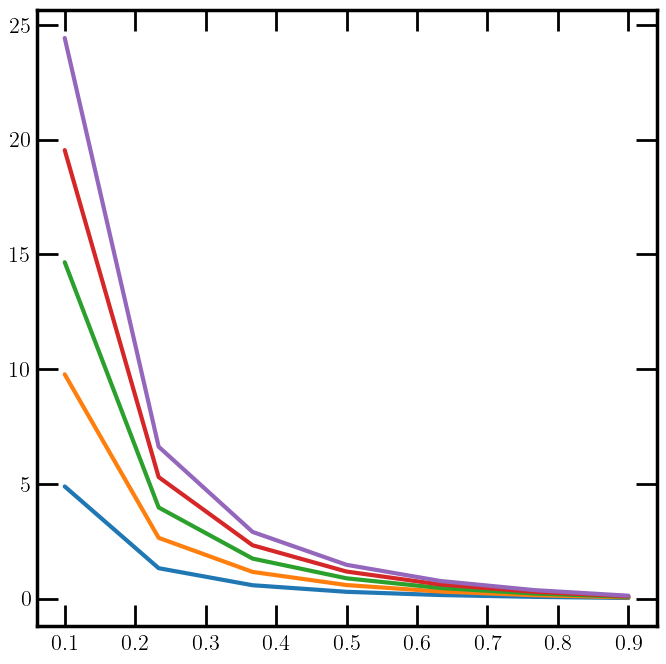

In [18]:
alphas = torch.linspace(0.1, 0.5, 5)
lambdas = torch.linspace(0.1, 0.9, 7)

p = LO_angularity(lambdas, alphas)
print(p.shape)

# plot the target distribution
for i, alpha in enumerate(alphas):
    plt.plot(lambdas, p[:,i], label = f"alpha = {alpha}", c = plt.cm.tab10(i))

/tmp/ipykernel_425161/2700199471.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label = r"$\alpha_s$")


(-1.5, 1.5)

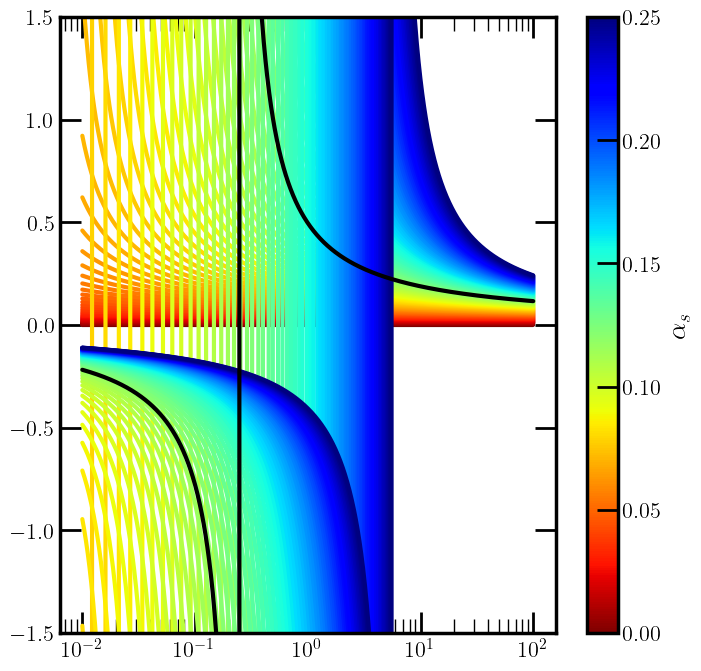

In [19]:
# running of alpha

Q = np.logspace(-2, 2, 1000)

alpha_choices = np.linspace(0, 0.25, 100)
# jet color scheme
cmap = plt.get_cmap("jet_r")
colors = cmap(np.linspace(0, 1, len(alpha_choices)))

for (i, alpha) in enumerate(alpha_choices):



    alphas = run_alpha(alpha, 91, torch.tensor(Q)).detach().numpy()
    plt.plot(Q, alphas, label = f"alpha = {alpha}", color = colors[i])

alphas = run_alpha(0.118, 91, torch.tensor(Q)).detach().numpy()


# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=0.25))
sm.set_array([])
plt.colorbar(sm, label = r"$\alpha_s$")

plt.plot(Q, alphas, label = f"alpha = 0.118", color = "black")
plt.xscale("log")

plt.ylim(-1.5, 1.5)
# plt.legend()

0.9919563953682835
0.9919563953682835
0.9919563953682835
0.9919563953682835


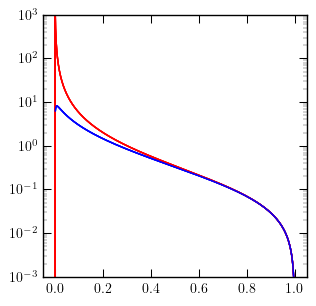

In [20]:
# Plot the target distribution

fig, ax = newplot("column")

for alpha in np.logspace(-3, 0, 4):

    alpha = torch.tensor(0.118)

    xs = np.linspace(0, 1, 1000)
    ys = target_p(torch.tensor(xs), alpha).detach().numpy()
    ax.plot(xs, ys, label="LL Angularity", color = "red")

    plt.yscale("log")

    # Plot the LL and LL_exact distributions
    xs = np.linspace(0.002, 0.999, 1000)
    ys = LL_angularity(torch.tensor(xs), alpha).detach().numpy()
    print(np.trapz(ys, xs))
    ax.plot(xs, ys, label="LL Angularity", color = "blue")

    # ys = LL_exact_angularity(torch.tensor(xs), alpha).detach().numpy()
    # print(np.trapz(ys, xs))
    # ax.plot(xs, ys, label="LL Exact Angularity", color = "green")

    plt.ylim(1e-3, 1e3)



In [21]:
from zuko.distributions import DiagNormal
from zuko.flows import UnconditionalDistribution

# Initialize the flow
global_losses = []
global_cs = []



# Can choose: NSF, MAF, NICE
flow = zuko.flows.BPF(features = auxiliary_params + 1, context=1, transforms= num_transforms, hidden_features=hidden_features, activation =torch.nn.GELU)

# # Hack to make the flow bounded between 0 and 1
# flow = zuko.flows.Flow(transform = [flow, AffineSigmoid(0,1)], base =UnconditionalDistribution(
#         DiagNormal,
#         torch.zeros(3),
#         torch.ones(3),
#         buffer=True,
#     ),)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def inverse_sigmoid(x):
    return torch.log(x / (1 - x))

def log_abs_det_jacobian_sigmoid(x,):
    sigma = sigmoid(x)
    return torch.abs(torch.log(sigma) + torch.log(1 - sigma))

def counting_parameter(x, C = 1):
    return C * alpha_s(E0 * x) * torch.log(1/x) / x 


print(flow)

# print list of all attributes of the flow
print(flow.__dict__.keys())



pytorch_total_params = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(f"Numb. trainable params: {pytorch_total_params}")


BPF(
  (transform): LazyComposedTransform(
    (0-2): 3 x ElementWiseTransform(
      (base): BoundedBernsteinTransform()
      (hyper): MLP(
        (0): Linear(in_features=1, out_features=8, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=8, out_features=8, bias=True)
        (3): GELU(approximate='none')
        (4): Linear(in_features=8, out_features=17, bias=True)
      )
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: tensor([0.]), scale: tensor([1.])))
)
dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules'])
Numb. trainable params: 723


In [22]:
from torch.autograd.functional import jacobian


# Training Loop

PLOT_EACH_EPOCH = False



def train(epochs, batch_size_x, batch_size_alpha, pre_train = False, lr = 1e-3):

    optimizer = torch.optim.AdamW(flow.parameters(), lr=lr)


    losses = []
    training_cs = []
    logps = []
    logqs = []
    logJs = []
    xss = []


    t = tqdm(range(epochs))

        # Sample a bunch of alphas from an exponential distribution
    # alpha_batch = torch.distributions.Exponential(1 / 0.118).sample((batch_size,))



    for epoch in t:

        # Generate a random cutoff alpha, exponentially distributed
        
        reroll = True
        while reroll:
            # alpha = torch.distributions.Exponential(1 / 0.118).sample()

            alpha = torch.distributions.Exponential(1 / 0.118).sample((batch_size_alpha,))
            # alpha = torch.rand(batch_conditional)
            if torch.all(alpha) > 0.001:
                reroll = False
                

        # x_range = (0.5, 0.99)
        c = torch.rand(1) * (x_range[1] - x_range[0]) + x_range[0]
        
        

        # Used to be called "REVERSE" / "No samples"
        if MODE == "UNIFORM_SAMPLES":

            reroll = True

            while reroll:
                xs = torch.rand(batch_size_x, auxiliary_params + 1)  * (x_range[1] - x_range[0]) + x_range[0] 
                # xs[:,0] = xs[:,0] * (1 - c) + c
                # xs = torch.zeros(batch_size, auxiliary_params + 1) 
                xs[:,0] = torch.linspace(0.001, 0.999, batch_size_x)

                # Auxillary variable -- uniform. alternatively set to const
                if auxiliary_params > 0:
                    xs[:,1:] = torch.rand(batch_size_x, auxiliary_params)
                    xs[:,1] = torch.linspace(0.001, 0.999, batch_size_x)

                # Check if any x are 0 or 1 to float point error, reroll if so
                epsilon = 1e-6
                if torch.any(xs <= epsilon) or torch.any(xs >= 1 - epsilon):
                    reroll = True
                else:
                    reroll = False

            # Note for log_prob to work, we need to pass a tensor of shape (batch_size, >=1)
            
            def q_given_alpha(xs, alpha):
                # return LL_angularity(xs[:,0], alpha)

                logJ = torch.nansum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)

                qs = torch.zeros((batch_size_x, alpha.shape[0]))
                for i in range(alpha.shape[0]):
                    qs[:,i] = (flow(alpha[i].reshape(1,1)).log_prob(inverse_sigmoid(xs)) + logJ).exp()
                return qs
            
            def p_given_alpha(xs, alpha):
                return (target_p(xs[:,0], alpha)) # * target_p(xs[:,1], alpha))


            epsilon = 1e-6
            def residual(xs, alpha):           
                p = p_given_alpha(xs, alpha) 
                q = q_given_alpha(xs, alpha)

                # return (p + epsilon) / (q + epsilon) # * LL_angularity(xs[:,0], alpha)
                # return  p_given_alpha(xs, alpha) - q_given_alpha(xs, alpha) # * LL_angularity(xs[:,0], alpha)
                return  1 * (torch.log((p + epsilon) / (q + epsilon))) #* (p + epsilon) / (q + epsilon) # * LL_angularity(xs[:,0], alpha)
            




            def helper_q(alpha):
                return q_given_alpha(xs, alpha)
            
            def helper_p(alpha):
                return p_given_alpha(xs, alpha)
            
            def q_derivative(alpha):

                # print(alpha.shape)
                q1 = torch.zeros((batch_size_x, batch_size_alpha))
                for (i, a) in enumerate(alpha):

                    a = torch.tensor([a.item(),])
                    q1[:,i] = jacobian(helper_q, a, create_graph=True, vectorize=False).diagonal(dim1=1, dim2=2)[:,0]

                return q1
            
            def p_derivative(alpha):
                    
                # print(alpha.shape)
                p1 = torch.zeros((batch_size_x, batch_size_alpha))
                for (i, a) in enumerate(alpha):
                    a = torch.tensor([a.item(),])
                    p1[:,i] = jacobian(helper_p, a, create_graph=True, vectorize=False).diagonal(dim1=1, dim2=2)[:,0]

                return p1
        


            if pre_train:
                
                loss = 0

                p = p_given_alpha(xs, alpha) 
                q = q_given_alpha(xs, alpha)

                logp = torch.log(torch.abs(p))
                argp = torch.where(p < 0, np.pi, 0)
                logq = torch.log(torch.abs(q))

                term1 = torch.square(logp - logq)
                term2 = torch.square(argp)


                weight = xs[:,0] / torch.log(1/xs[:,0])*0 + 1

                # print(weight.shape, term1.shape, term2.shape)
                reg_loss = 0.1 * torch.nanmean(weight[:,None] * (term1 + term2))
                loss = torch.nanmean(weight[:,None] * (term1 + term2))

                if epoch == 0:
                    loss_norm = loss.item()
                
                loss = loss / loss_norm 


            else:

                # p = torch.abs(p_given_alpha(xs, alpha))
                # q = q_given_alpha(xs, torch.tensor([alpha.item(),]))
            
                alpha_0 = torch.zeros_like(alpha)
                loss = 0
                residual_0 = q_given_alpha(xs, alpha_0)
                residual_1 = q_derivative(alpha_0)

                p_0 = p_given_alpha(xs, alpha_0)
                p_1 = p_derivative(alpha_0)

                # without gradients, divide by the mean of the residuals
                with torch.no_grad():

                    if epoch == 0:
                        residual_0_norm = 1 + 0*(torch.mean(residual_0 + epsilon) * 10)
                        residual_1_norm =  1 + 0*(torch.mean(residual_1 + epsilon) * 10)
                
                # residual_0 = residual_0 / residual_0_norm
                # residual_1 = residual_1 / residual_1_norm

                q_derivatives = [residual_0, residual_1]
                p_derivatives = [p_0, p_1]
                # print(residual_0, residual_1)

                N = 1

                def taylor_q_given_alpha(xs, alpha):
                    temp = 0
                    for n in range(N + 1):
                        temp += torch.pow(alpha, n) * q_derivatives[n] / torch.math.factorial(n)
                    return temp

                def taylor_p_given_alpha(xs, alpha):
                    temp = 0
                    for n in range(N + 1):
                        temp += torch.pow(alpha, n) * p_derivatives[n] / torch.math.factorial(n)
                    return temp

                # def taylor_p_given_alpha(xs, alpha):
                #     return target_p(xs[:,0], alpha)
                
                def taylor_residual(xs, alpha):
                    return torch.nan_to_num((torch.log(taylor_p_given_alpha(xs, alpha) + epsilon) - torch.log(taylor_q_given_alpha(xs, alpha) + epsilon ) ))
                
                # alpha_tensor = torch.tensor([alpha.item(),])
                weight = Theta(xs - 0.0)[:,0]
                total_loss = weight[:,None] * taylor_residual(xs, alpha)  * taylor_residual(xs, alpha) #  (torch.log(q + epsilon) - torch.log(p + epsilon)) 
                loss = total_loss.mean()



                # Regularization
                p = p_given_alpha(xs, alpha) 
                q = q_given_alpha(xs, alpha)

                logp = torch.log(torch.abs(p))
                argp = torch.where(p < 0, np.pi, 0)
                logq = torch.log(torch.abs(q))

                term1 = torch.square(logp - logq)
                term2 = torch.square(argp)

                reg_loss = 1 * torch.nanmean(weight[:,None] * (term1 + term2))
                loss += 0.1*reg_loss

                # reg_loss = torch.tensor(0.0)



                if epoch == 0:
                    loss_norm = loss.item()

                
                # loss = loss / loss_norm 


              
                d_losses = []


                for n in range(N + 1):
                    # sum_derivatives += torch.pow(alpha_batch[None, :], n) *  derivatives[n][:,None] / torch.math.factorial(n)
                    d_losses.append(torch.nanmean(weight[:,None] * ((q_derivatives[n] + epsilon) - (p_derivatives[n] + epsilon))**2))

    
            


        loss.backward()


        # Gradient Descent
        optimizer.step()
        optimizer.zero_grad()


        training_cs.append(alpha.mean())
        losses.append(loss.item())

        global_losses.append(loss.item())
        global_cs.append(alpha.mean())
        # t.set_description(f"Loss: {loss.item()  }, Aux Loss: {loss_aux.item() } (Fraction: {loss_aux.item() / loss.item() })")
        
        if pre_train:
            t.set_description(f"Loss: {loss.item()  }")
        else:

            t.set_description(f"Loss: {loss.item()}, Reg Losses {reg_loss.item()}, d_Losses: {d_losses}")

    return losses, training_cs, 


def logq_given_alpha(xs, alpha):
    logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
    ys = (flow(alpha).log_prob(inverse_sigmoid(xs)) + logJ) #* LL_angularity(xs[:,0], c)
    return ys


In [23]:
# empty numpy arrays to store the results
losses = np.zeros((1,))
training_cs = np.zeros((1,))



Loss: 0.5201274752616882: 100%|██████████| 1000/1000 [02:29<00:00,  6.67it/s]
Loss: 8.897216796875, Reg Losses 12.00669002532959, d_Losses: [tensor(59.9211, grad_fn=<DivBackward0>), tensor(3357700.5000, grad_fn=<DivBackward0>)]: 100%|██████████| 100/100 [09:00<00:00,  5.41s/it]    


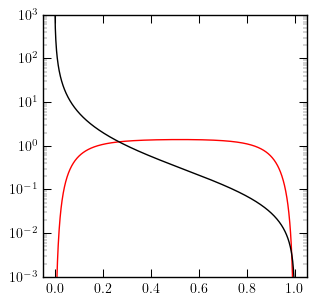

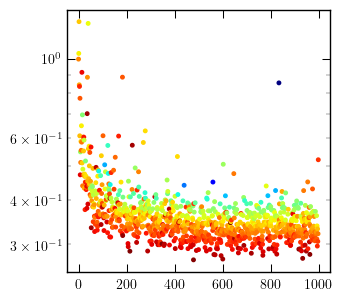

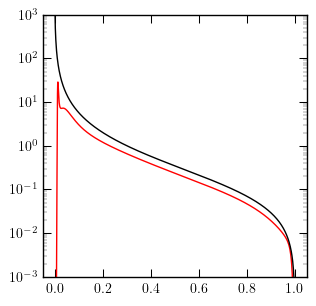

In [24]:

fig, ax = newplot("column")
xs = 0.5 * torch.rand((1000, auxiliary_params + 1))
xs[:,0] = torch.linspace(0.001, 0.999, 1000)
ys = logq_given_alpha(xs, torch.tensor([0.118])).exp().detach().numpy()
ax.plot(xs[:,0], ys, label="test", color = "red")
ys = target_p(xs[:,0], torch.tensor([0.118])).detach().numpy()
ax.plot(xs[:,0], ys, label="test", color = "black")
plt.ylim(1e-3, 1e3)
plt.yscale("log")

losses, training_cs =  train(epochs = 1000, batch_size_x = 512, batch_size_alpha=8, pre_train = True, lr = 1e-2)
torch.save(flow.state_dict(), f"rikab_model")

fig, ax = newplot("column")

cmap = plt.get_cmap("jet")

losses = np.array(losses)
training_cs = np.array(training_cs)

ax.scatter(np.arange(len(losses)), losses, c = 1-training_cs[:len(training_cs)], cmap = cmap)
plt.yscale("log")

fig, ax = newplot("column")
xs = 0.5 * torch.rand((1000, auxiliary_params + 1))
xs[:,0] = torch.linspace(0.001, 0.999, 1000)
ys = logq_given_alpha(xs, torch.tensor([0.118])).exp().detach().numpy()
ax.plot(xs[:,0], ys, label="test", color = "red")
ys = target_p(xs[:,0], torch.tensor([0.118])).detach().numpy()
ax.plot(xs[:,0], ys, label="test", color = "black")
plt.ylim(1e-3, 1e3)
plt.yscale("log")




# flow.load_state_dict(torch.load("model_taylor"))
# flow.eval()
losses_, training_cs_ =  train(epochs = 100, batch_size_x = 64, batch_size_alpha= 8, pre_train = False, lr = 1e-2)
torch.save(flow.state_dict(), f"model_taylor")

losses = np.concatenate([losses, losses_])
training_cs = np.concatenate([training_cs, training_cs_])



0.11756179 0.04271519


/tmp/ipykernel_425161/226743744.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label = r"$\alpha_s$")


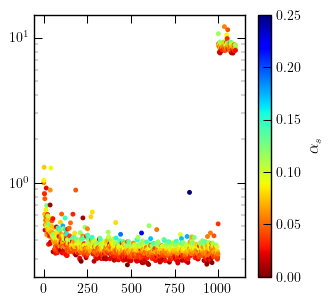

In [25]:

cmap = plt.get_cmap("jet_r")
colors = cmap(training_cs)

np_losses = np.array(global_losses)
np_cs = np.array(global_cs)
print(np_cs.mean(), np_cs.std())

fig, ax = newplot("column")
ax.scatter(np.arange(len(np_losses)), np_losses, c = np_cs, cmap = cmap)



sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=0.25))
sm.set_array([])
plt.colorbar(sm, label = r"$\alpha_s$")





plt.yscale("log")

tensor([0.2500, 0.2222, 0.1944, 0.1667, 0.1389, 0.1111, 0.0833, 0.0556, 0.0278,
        0.0000])


/tmp/ipykernel_425161/287833743.py:91: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label=r"$\alpha_s(m_Z)$")


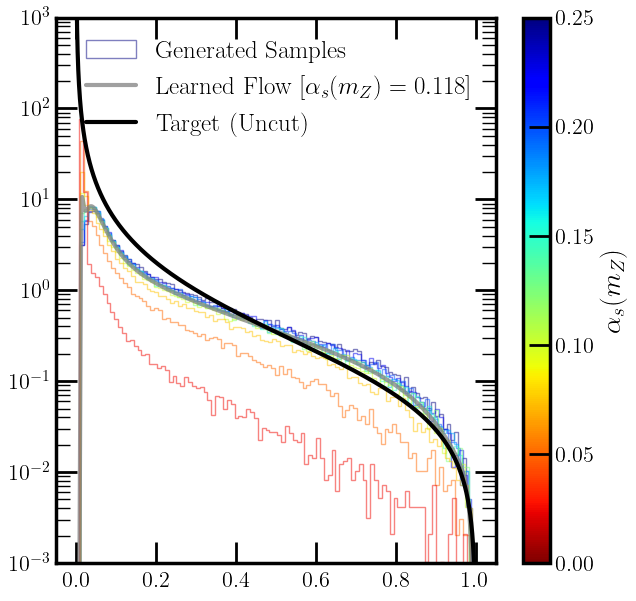

In [26]:
# Plot distribution of xs

fig, ax = newplot("full")
cs = torch.linspace(0, 0.25, 10).flip(0)
print(cs)

# cs = [0.5]

DRAW_NF_HIST = True
DRAW_NF_LINES = False
aux_draws = 5


for i in range(len(cs)):


    # Draw hist
    c = torch.tensor([cs[i],])

    if DRAW_NF_HIST:
        samples = sigmoid(flow(c).sample((100000,)))
        x_samples = samples[:,0].detach().numpy()
        aux_samples = samples[:,1:].detach().numpy()

        jet_color = plt.get_cmap("jet")(  i / 10)
        if i == 0:
            label = "Generated Samples"
        else:
            label = None
        ax.hist(x_samples, bins=100, density=True, color = jet_color, alpha = 0.5, label = label, histtype="step")

    if DRAW_NF_LINES:

        for aux_draw in range(1):
            xs = torch.rand(10000, auxiliary_params + 1) * (x_range[1] - x_range[0]) + x_range[0]
            
            # Sort the first column
            xs = xs[torch.argsort(xs[:,0])]
            xs[:,1:] = torch.rand(1) * torch.rand((10000, auxiliary_params))
            

            # logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
            ys = logq_given_alpha(xs, c).exp() #* LL_angularity(xs[:,0], c)

            xs = xs[:,0].detach().numpy().flatten()
            ys = np.nan_to_num(ys.detach().numpy().flatten())

            print (c, np.trapz(ys, xs))

            np.save(f"plotfiles/theta_ys_{cs[i]}.npy", np.array([xs, ys]))


            jet_color = plt.get_cmap("jet")( i / 10)
            if i == 0 and aux_draw == 0:
                label = "Learned Flow"
            else:
                label = None

            ax.plot(xs, ys, color = jet_color, lw = 1, alpha = 0.5, label = label)

            # ax.vlines(cs[i], 0, target_p(c), color = jet_color, linestyle = "--", alpha = 0.25, lw = 0.5)



alpha0 = torch.tensor([0.118 / 1,])
xs = torch.rand(10000, auxiliary_params + 1) * (x_range[1] - x_range[0]) + x_range[0]
            
# Sort the first column
xs = xs[torch.argsort(xs[:,0])]
xs[:,1:] = torch.rand(1) * torch.rand((10000, auxiliary_params))


logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
ys = (flow(alpha0).log_prob(inverse_sigmoid(xs)) + logJ).exp() #* LL_angularity(xs[:,0], c)

xs = xs[:,0].detach().numpy().flatten()
ys = np.nan_to_num(ys.detach().numpy().flatten())
ax.plot(xs, ys, color = "grey", lw = 3, alpha = 0.75, label = r"Learned Flow [$\alpha_s(m_Z) = 0.118$]" )



plt.plot(xs, target_p(torch.tensor(xs), alpha0)[:,0], color = "Black", label = "Target (Uncut)")
# plt.plot(xs, LL_angularity(torch.tensor(xs), alpha0)[:,0], color = "black", linestyle = "--", label = "LL Angularity", alpha = 1)
# plt.plot(xs, LL_angularity(torch.tensor(xs), alpha0), color = "black", linestyle = "--", label = "LL-exact Angularity")



# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("jet_r"), norm=plt.Normalize(vmin=0, vmax=cs[0]))
sm.set_array([])
plt.colorbar(sm, label=r"$\alpha_s(m_Z)$")




# c = torch.tensor((0.5,))
# xs = torch.zeros((10000, auxiliary_params + 1)) + 0.5
# xs[:,0] = torch.linspace(0.001, 0.999, 10000)
# logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
# ys = (flow(c).log_prob(inverse_sigmoid(xs)) + logJ).exp()

# print(flow(c).log_prob(inverse_sigmoid(xs)))
# print(ys)

# xs = xs[:,0].detach().numpy().flatten()
# ys = np.nan_to_num(ys.detach().numpy().flatten())
# ps = target_p(torch.tensor(xs)).detach().numpy().flatten()
# plt.plot(xs, ys, color = "red", label = "Learned Flow")
# print(ys.mean())

# c = c.detach().numpy()

cutoff = xs > 0.5


# cutoff_norm = np.trapz(ps * cutoff, xs)
# plt.plot(xs, cutoff * ps , color = "grey", label = rf"Target (Cut at $c$ = {cs[0]})")

plt.legend()

plt.yscale("log")

plt.ylim(1e-3, 1e3)

c = torch.tensor((0.5,))
samples = sigmoid(flow(c).sample((100000,)))
x_samples = samples[:,0].detach().numpy()
aux_samples = samples[:,1:].detach().numpy()


# plot the auxiliary variables
if auxiliary_params > 0:
    fig, ax = newplot("column")
    for i in range(auxiliary_params):
        plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
        prob = flow(c).log_prob(samples).exp()
        # plt.scatter(aux_samples[:,i], prob.detach().numpy(), color = "red")

    plt.yscale("log")   
    plt.ylim(1e-3, 1e3)
    plt.legend()

    # correlation between auxiliary variable 1 and x
    import matplotlib as mpl
    fig, ax = newplot("column")
    bar = ax.hist2d(x_samples, aux_samples[:,0], bins=100, density=True, norm=mpl.colors.LogNorm(), cmap="Reds")
    plt.colorbar(bar[3])
    plt.xlabel("x")
    plt.ylabel("Aux 0")
#im not sure that f(x) itself is ~ p(x)



tensor([0.2500])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
tensor([0.2233])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
tensor([0.1967])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
tensor([0.1700])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
tensor([0.1433])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
tensor([0.1167])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
tensor([0.0900])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
tensor([0.0633])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
tensor([0.0367])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
tensor([0.0100])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])
torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([1]) torch.Size([1])


/tmp/ipykernel_425161/1609300908.py:85: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label = r"$\alpha_s$")


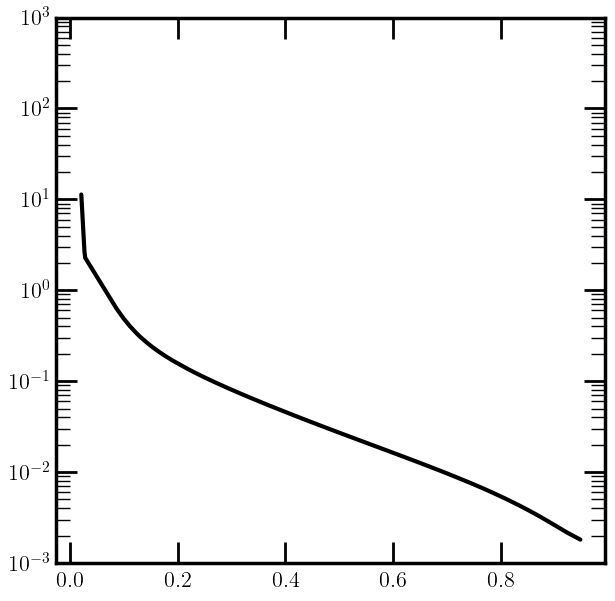

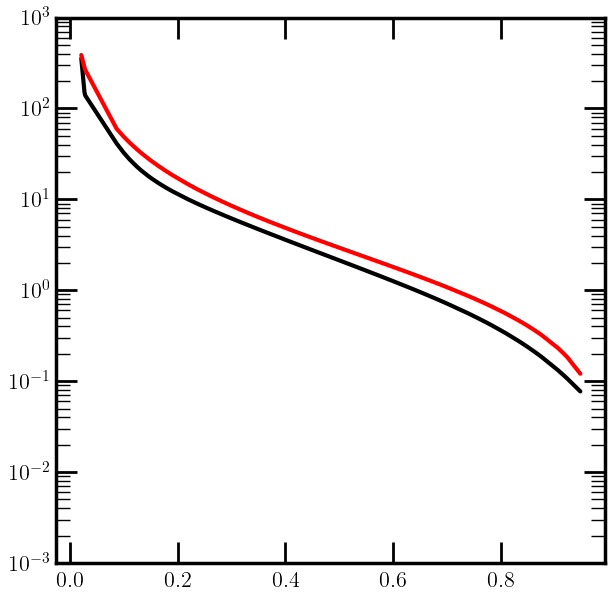

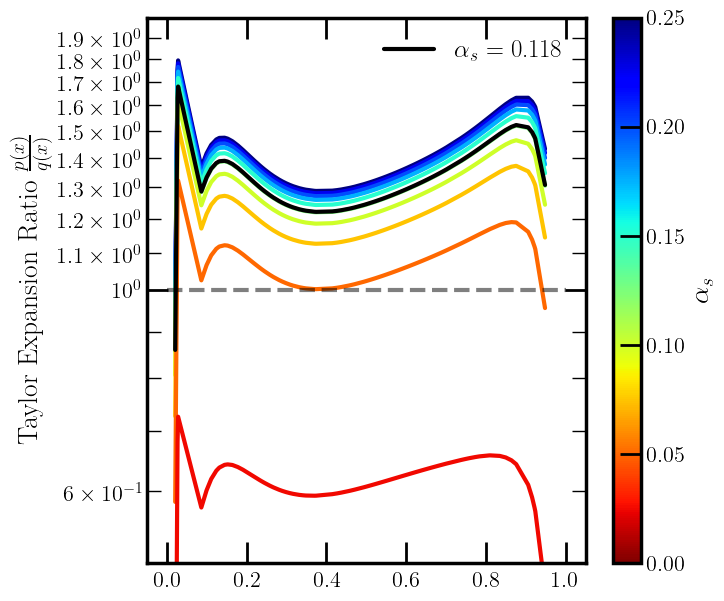

In [27]:



# flow = zuko.flows.BPF(features = auxiliary_params + 1, context=1, transforms= num_transforms, hidden_features=hidden_features)

# flow.load_state_dict(torch.load("model_taylor"))
# flow.eval()

alpha0 = torch.tensor([0.0,])
xs = torch.rand(100, auxiliary_params + 1) * (0.99- 0.01) + 0.01
xs = xs.sort(axis = 0).values
p0 = target_p(xs[:,0], alpha0)
p1 = jacobian(lambda a: target_p(xs[:,0], a), alpha0, vectorize=True)[:,0]

p0_LL = LL_angularity(xs[:,0], alpha0)
p1_LL = jacobian(lambda a: LL_angularity(xs[:,0], a), alpha0, vectorize=True)[:,0]


def q_given_alpha(xs, alpha):   
    return logq_given_alpha(xs, alpha).exp()
q0 = q_given_alpha(xs, alpha0)
q1 = jacobian(lambda a: q_given_alpha(xs, a), alpha0, vectorize=True)[:,0]

def taylor_p(x, alpha):
    print(p0.shape, p1.shape, alpha.shape, alpha0.shape)
    return p0 + p1 * (alpha - alpha0)

def taylor_p_LL(x, alpha):
    return p0_LL + p1_LL * (alpha - alpha0)

def taylor_q(x, alpha):
    return q0 + q1 * (alpha - alpha0) 

fig, ax = newplot("full")
plt.plot(xs[:,0].detach().numpy(), q0.detach().numpy(), color = "black", label = "p0")
plt.plot(xs[:,0].detach().numpy(), p0.detach().numpy(), color = "red", label = "p1")
plt.yscale("log")
plt.ylim(1e-3, 1e3)

fig, ax = newplot("full")
plt.plot(xs[:,0].detach().numpy(), q1.detach().numpy(), color = "black", label = "p0")
plt.plot(xs[:,0].detach().numpy(), p1.detach().numpy(), color = "red", label = "p1")
plt.yscale("log")
plt.ylim(1e-3, 1e3)

fig, ax = newplot("full")


alphas = torch.linspace(0.01, 0.25, 10).flip(0)
for i in range(alphas.shape[0]):
    alpha = torch.tensor([alphas[i],])
    print(alpha)
    jet_color = plt.get_cmap("jet")(  i / 10)

    # ys = taylor_p(xs, alpha).detach().numpy()
    # ax.plot(xs[:,0].detach().numpy(), ys, color = "red", alpha = (i+1)/3, label = f"Taylor p {alpha.item() : .3f}")
    # print(ys.shape)

    # ys = taylor_q(xs, alpha).detach().numpy()
    # ax.plot(xs[:,0].detach().numpy(), ys, color = "blue", alpha = (i+1)/3, label = f"Taylor q {alpha.item() : .3f}")
    # print(ys.shape)
    # ax.set_yscale("log")

    # # ys = target_p(xs[:,0], alpha).detach().numpy()
    # # ax.plot(xs[:,0].detach().numpy(), ys, color = "black", alpha = (i+1)/3, label = f"Target {alpha.item() : .3f}")

    # plt.yscale("log")
    
    # # print(taylor_p(xs, alpha).shape)
    # # print(taylor_q(xs, alpha).shape)

    ratio = taylor_p(xs, alpha)[:,0] / taylor_q(xs, alpha)

    ax.plot(xs[:,0].detach().numpy(), ratio.detach().numpy(), color = jet_color)


# same but for alpha = 0.118
alpha = torch.tensor([0.118,])
ratio = taylor_p(xs, alpha)[:,0] / taylor_q(xs, alpha)
ax.plot(xs[:,0].detach().numpy(), ratio.detach().numpy(), color = "black", label = r"$\alpha_s$ = 0.118")
plt.ylabel  (r"Taylor Expansion Ratio $\frac{p(x)}{q(x)}$")



# colorbar
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("jet_r"), norm=plt.Normalize(vmin=0, vmax= 0.25))
sm.set_array([])
plt.colorbar(sm, label = r"$\alpha_s$")

plt.yscale("log")

plt.ylim(0.5, 2)


# add a lot of minor yticks
plt.yticks(np.arange(0.5, 2, 0.1), minor=True)



# line at 1
ax.hlines(1, 0, 1, color = "black", linestyle = "--", alpha = 0.5)

ax.legend()


In [28]:
# #  Plot distribution of xs


# samples = flow().sample((100000,)).detach().numpy()
# x_samples = samples[:,0]
# aux_samples = samples[:,1:]

# fig, ax = newplot("column")

# plt.hist(x_samples, bins=100, density=True, color = "red", alpha = 0.5)


# xs = torch.zeros((1000, auxiliary_params + 1))
# xs[:,0] = torch.linspace(-0.5, 1.5, 1000)
# ys = flow().log_prob(xs).exp()

# xs = xs[:,0].detach().numpy().flatten()
# ys = ys.detach().numpy().flatten()
# plt.plot(xs, ys, color = "red")


# plt.plot(xs, target_p(torch.tensor(xs)), color = "blue")

# plt.yscale("log")

# # plot the auxiliary variables
# if auxiliary_params > 0:
#     fig, ax = newplot("column")
#     for i in range(auxiliary_params):
#         plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
#         plt.plot(xs, ys, color = "red")
#     plt.legend()
